In [3]:
# --- standard ---
import os
import math
import numpy as np

# --- torch ---
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- PyTorch Geometric ---
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

# --- ML utils ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    roc_curve
)

# --- plotting ---
import matplotlib.pyplot as plt


In [4]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [161]:
# Graph construction
DR_CUT = 2.4

# Training
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 1e-3

# Model
NODE_FEATURE_DIM = 10   
NUM_CLASSES = 2         # QCD vs Higgs


In [162]:
import uproot
import awkward as ak
import numpy as np


In [163]:
root_path = "/home/sandeep/Desktop/combined_qcd_higgs.root"
tree_name = "tree"

file = uproot.open(root_path)
tree = file[tree_name]

tree.show()


name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
npart_px             | int32_t                  | AsDtype('>i4')
part_px              | float[]                  | AsJagged(AsDtype('>f4'))
npart_py             | int32_t                  | AsDtype('>i4')
part_py              | float[]                  | AsJagged(AsDtype('>f4'))
npart_pz             | int32_t                  | AsDtype('>i4')
part_pz              | float[]                  | AsJagged(AsDtype('>f4'))
npart_energy         | int32_t                  | AsDtype('>i4')
part_energy          | float[]                  | AsJagged(AsDtype('>f4'))
npart_deta           | int32_t                  | AsDtype('>i4')
part_deta            | float[]                  | AsJagged(AsDtype('>f4'))
npart_dphi           | int32_t                  | AsDtype('>i4')
part_dphi            | float[]                  | AsJagged(AsDtype('>f4')

In [164]:
arrays = tree.arrays(
    [
        "part_px",
        "part_py",
        "part_pz",
        "part_energy",
        "part_charge",
        "part_isChargedHadron",
        "part_isNeutralHadron",
        "part_isPhoton",
        "part_isElectron",
        "part_isMuon",
        "class_id",
    ],
    library="ak"
)


In [165]:
num_jets = len(arrays["class_id"])
print("Number of jets:", num_jets)


Number of jets: 37870


In [166]:
n_particles = ak.num(arrays["part_px"])
print("Particles per jet:")
print("  min:", ak.min(n_particles))
print("  mean:", ak.mean(n_particles))
print("  max:", ak.max(n_particles))


Particles per jet:
  min: 1
  mean: 35.36870874042778
  max: 202


In [167]:
labels = ak.to_numpy(arrays["class_id"])   # per-jet labels (length = num_jets)

unique_labels, counts = np.unique(labels, return_counts=True)

print("Label distribution:", dict(zip(unique_labels, counts)))



Label distribution: {0: 16780, 1: 21090}


In [168]:
print("labels shape:", labels.shape)
print("first 10 labels:", labels[:10])


labels shape: (37870,)
first 10 labels: [0 0 0 0 0 0 0 0 0 0]


ak.stack ❌ does not exist in Awkward v2

The correct modern way is to use ak.zip to build structured arrays,
or ak.concatenate(..., axis=-1) after adding a dimension

In [169]:
particle_features = [
    arrays["part_px"][:, :, None],
    arrays["part_py"][:, :, None],
    arrays["part_pz"][:, :, None],
    arrays["part_energy"][:, :, None],
    arrays["part_charge"][:, :, None],
    arrays["part_isChargedHadron"][:, :, None],
    arrays["part_isNeutralHadron"][:, :, None],
    arrays["part_isPhoton"][:, :, None],
    arrays["part_isElectron"][:, :, None],
    arrays["part_isMuon"][:, :, None],
]


In [170]:
particles = ak.concatenate(particle_features, axis=-1)


In [171]:
print("Particle structure:", ak.type(particles))


Particle structure: 37870 * var * 10 * float64


In [172]:
ak.num(particles[0])


<Array [10, 10, 10, 10, 10, 10, ..., 10, 10, 10, 10, 10, 10] type='27 * int64'>

In [173]:
print("Particles in jet 0:", ak.num(particles[0]))
print("First particle features:", particles[0][0])
print("Feature vector length:", len(particles[0][0]))


Particles in jet 0: [10, 10, 10, 10, 10, 10, 10, 10, 10, ..., 10, 10, 10, 10, 10, 10, 10, 10, 10]
First particle features: [-195, 24, -284, 345, -1, 1, 0, 0, 0, 0]
Feature vector length: 10


In [174]:
jet0_np = ak.to_numpy(particles[0])
print(jet0_np.shape)


(27, 10)


In [175]:
def compute_eta_phi(px, py, pz, eps=1e-8):
    pt = np.sqrt(px**2 + py**2) + eps
    p  = np.sqrt(px**2 + py**2 + pz**2) + eps
    eta = 0.5 * np.log((p + pz) / (p - pz + eps))
    phi = np.arctan2(py, px)
    return eta, phi


In [176]:
def delta_r(eta1, phi1, eta2, phi2):
    dphi = phi1 - phi2
    dphi = (dphi + np.pi) % (2 * np.pi) - np.pi
    deta = eta1 - eta2
    return np.sqrt(deta**2 + dphi**2)


In [177]:
def build_edges_for_jet(px, py, pz, dr_cut=0.4):
    eta, phi = compute_eta_phi(px, py, pz)
    n = len(px)

    edge_src = []
    edge_dst = []

    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            if delta_r(eta[i], phi[i], eta[j], phi[j]) < dr_cut:
                edge_src.append(i)
                edge_dst.append(j)

    if len(edge_src) == 0:
        # isolated jet fallback: self-loops
        edge_src = list(range(n))
        edge_dst = list(range(n))

    edge_index = torch.tensor(
        [edge_src, edge_dst], dtype=torch.long
    )

    return edge_index


In [178]:
from torch_geometric.data import Data

def build_graph_for_jet(particles_jet, label):
    """
    particles_jet: awkward or numpy, shape (num_particles, 10)
    label: int (0 or 1)
    """

    # Convert node features
    x = torch.tensor(
        ak.to_numpy(particles_jet),
        dtype=torch.float
    )

    # Extract momentum for edge building
    px = x[:, 0].numpy()
    py = x[:, 1].numpy()
    pz = x[:, 2].numpy()

    edge_index = build_edges_for_jet(px, py, pz)

    y = torch.tensor(label, dtype=torch.long)

    return Data(x=x, edge_index=edge_index, y=y)


In [179]:
from tqdm import tqdm

In [180]:
graphs = []

for i in tqdm(range(len(particles)), desc="Building jet graphs"):
    n_part = len(particles[i])   # ← CORRECT

    if n_part < 2:
        continue

    graph = build_graph_for_jet(
        particles[i],
        labels[i]
    )
    graphs.append(graph)

Building jet graphs: 100%|██████████| 37870/37870 [03:52<00:00, 162.59it/s]


In [181]:
print("Particles in jet 0:", len(particles[0]))
print("Feature vector length:", len(particles[0][0]))


Particles in jet 0: 27
Feature vector length: 10


In [182]:
print("Total graphs:", len(graphs))
print("Example graph:", graphs[0])


Total graphs: 36991
Example graph: Data(x=[27, 10], edge_index=[2, 588], y=0)


In [183]:
from sklearn.model_selection import train_test_split

labels_for_split = [g.y.item() for g in graphs]

train_graphs, val_graphs = train_test_split(
    graphs,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=labels_for_split
)

print("Train graphs:", len(train_graphs))
print("Val graphs:", len(val_graphs))


Train graphs: 29592
Val graphs: 7399


In [184]:
import torch

os.makedirs("saved_graphs", exist_ok=True)

torch.save(train_graphs, "saved_graphs/train_graphs.pt")
torch.save(val_graphs,   "saved_graphs/val_graphs.pt")

print("Graphs saved.")


Graphs saved.


In [247]:
from torch_geometric.loader import DataLoader

BATCH_SIZE = 128

train_loader = DataLoader(
    train_graphs,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

val_loader = DataLoader(
    val_graphs,
    batch_size=BATCH_SIZE,
    shuffle=False
)


In [248]:
batch = next(iter(train_loader))

print(batch)
print("batch.x shape:", batch.x.shape)
print("batch.edge_index shape:", batch.edge_index.shape)
print("batch.y shape:", batch.y.shape)
print("batch.batch shape:", batch.batch.shape)


DataBatch(x=[4847, 10], edge_index=[2, 166742], y=[128], batch=[4847], ptr=[129])
batch.x shape: torch.Size([4847, 10])
batch.edge_index shape: torch.Size([2, 166742])
batch.y shape: torch.Size([128])
batch.batch shape: torch.Size([4847])


In [249]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import (
    GCNConv,
    global_mean_pool,
    global_max_pool
)

class JetGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim=256, num_classes=2, dropout=0.3):
        super().__init__()

        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)

        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)

        self.dropout = nn.Dropout(dropout)

        # Mean + Max pooling → 2 * hidden_dim
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x, edge_index, batch):
        # Layer 1
        h1 = self.conv1(x, edge_index)
        h1 = self.bn1(h1)
        h1 = F.relu(h1)

        # Layer 2 (residual)
        h2 = self.conv2(h1, edge_index)
        h2 = self.bn2(h2)
        h2 = F.relu(h2)
        h2 = h2 + h1   # residual
        h2 = self.dropout(h2)

        # Layer 3 (residual)
        h3 = self.conv3(h2, edge_index)
        h3 = self.bn3(h3)
        h3 = F.relu(h3)
        h3 = h3 + h2   # residual

        # Pool node → jet
        x_mean = global_mean_pool(h3, batch)
        x_max  = global_max_pool(h3, batch)
        x = torch.cat([x_mean, x_max], dim=1)

        return self.fc(x)


In [ ]:
# from torch_geometric.nn import (
#     GINEConv,
#     global_mean_pool,
#     global_max_pool
# )


In [ ]:
# def global_std_pool(x, batch, eps=1e-6):
#     mean = global_mean_pool(x, batch)
#     mean_sq = global_mean_pool(x * x, batch)
#     return torch.sqrt(mean_sq - mean * mean + eps)


In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch_geometric.nn import (
#     GCNConv,
#     global_mean_pool,
#     global_max_pool
# )

# class JetGNN(nn.Module):
#     def __init__(self, in_dim, hidden_dim=256, num_classes=2, dropout=0.25):
#         super().__init__()

#         self.conv1 = GCNConv(in_dim, hidden_dim)
#         self.bn1 = nn.BatchNorm1d(hidden_dim)

#         self.conv2 = GCNConv(hidden_dim, hidden_dim)
#         self.bn2 = nn.BatchNorm1d(hidden_dim)

#         self.conv3 = GCNConv(hidden_dim, hidden_dim)
#         self.bn3 = nn.BatchNorm1d(hidden_dim)

#         self.conv4 = GCNConv(hidden_dim, hidden_dim)
#         self.bn4 = nn.BatchNorm1d(hidden_dim)

#         self.conv5 = GCNConv(hidden_dim, hidden_dim)
#         self.bn5 = nn.BatchNorm1d(hidden_dim)

#         self.dropout = nn.Dropout(dropout)

#         # Mean + Max pooling → 2 * hidden_dim (UNCHANGED)
#         self.fc = nn.Sequential(
#             nn.Linear(2 * hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dim, hidden_dim // 2),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(hidden_dim // 2, num_classes)
#         )

#     def forward(self, x, edge_index, batch):
#         # Layer 1
#         h1 = F.relu(self.bn1(self.conv1(x, edge_index)))
#         h1 = self.dropout(h1)

#         # Layer 2 (residual)
#         h2 = F.relu(self.bn2(self.conv2(h1, edge_index)))
#         h2 = h2 + h1
#         h2 = self.dropout(h2)

#         # Layer 3 (residual)
#         h3 = F.relu(self.bn3(self.conv3(h2, edge_index)))
#         h3 = h3 + h2
#         h3 = self.dropout(h3)

#         # Layer 4 (residual)
#         h4 = F.relu(self.bn4(self.conv4(h3, edge_index)))
#         h4 = h4 + h3
#         h4 = self.dropout(h4)

#         # Layer 5 (residual)
#         h5 = F.relu(self.bn5(self.conv5(h4, edge_index)))
#         h5 = h5 + h4

#         # Pool node → jet (UNCHANGED)
#         x_mean = global_mean_pool(h5, batch)
#         x_max  = global_max_pool(h5, batch)
#         x = torch.cat([x_mean, x_max], dim=1)

#         return self.fc(x)


In [250]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = JetGNN(in_dim=10).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


In [251]:
batch = next(iter(train_loader)).to(device)

out = model(batch.x, batch.edge_index, batch.batch)

print("Output shape:", out.shape)


Output shape: torch.Size([128, 2])


In [252]:
train_graphs = torch.load(
    "saved_graphs/train_graphs.pt",
    weights_only=False
)

val_graphs = torch.load(
    "saved_graphs/val_graphs.pt",
    weights_only=False
)

print(len(train_graphs), len(val_graphs))


29592 7399


In [253]:
g = train_graphs[0]
print(g)
print(g.x.shape, g.edge_index.shape, g.y)


Data(x=[60, 10], edge_index=[2, 1586], y=1)
torch.Size([60, 10]) torch.Size([2, 1586]) tensor(1)


In [254]:
from torch_geometric.loader import DataLoader

BATCH_SIZE = 64

train_loader = DataLoader(
    train_graphs,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

val_loader = DataLoader(
    val_graphs,
    batch_size=BATCH_SIZE,
    shuffle=False
)


In [255]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for batch in loader:
        batch = batch.to(device)

        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch.num_graphs

    return total_loss / len(loader.dataset)


In [256]:
from sklearn.metrics import roc_auc_score

@torch.no_grad()
def validate(model, loader, device):
    model.eval()

    all_scores = []
    all_labels = []

    for batch in loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)

        probs = torch.softmax(out, dim=1)[:, 1]  # Higgs score
        all_scores.append(probs.cpu())
        all_labels.append(batch.y.cpu())

    all_scores = torch.cat(all_scores).numpy()
    all_labels = torch.cat(all_labels).numpy()

    auc = roc_auc_score(all_labels, all_scores)
    return auc


In [257]:
@torch.no_grad()
def validate_loss(model, loader, criterion, device):
    model.eval()
    total_loss = 0

    for batch in loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        total_loss += loss.item() * batch.num_graphs

    return total_loss / len(loader.dataset)


In [258]:
EPOCHS = 10

train_losses = []
val_losses = []
val_aucs = []

for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )
    val_loss = validate_loss(
        model, val_loader, criterion, device
    )
    val_auc = validate(model, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_aucs.append(val_auc)

    print(
        f"Epoch {epoch:02d} | "
        f"train loss={train_loss:.4f} | "
        f"val loss={val_loss:.4f} | "
        f"val AUC={val_auc:.4f}"
    )


Epoch 01 | train loss=0.6593 | val loss=0.6378 | val AUC=0.6723
Epoch 02 | train loss=0.6137 | val loss=0.6054 | val AUC=0.7244
Epoch 03 | train loss=0.5892 | val loss=0.5888 | val AUC=0.7405
Epoch 04 | train loss=0.5817 | val loss=0.5761 | val AUC=0.7582
Epoch 05 | train loss=0.5749 | val loss=0.5713 | val AUC=0.7546
Epoch 06 | train loss=0.5689 | val loss=0.5734 | val AUC=0.7595
Epoch 07 | train loss=0.5665 | val loss=0.5686 | val AUC=0.7664
Epoch 08 | train loss=0.5641 | val loss=0.5613 | val AUC=0.7704
Epoch 09 | train loss=0.5607 | val loss=0.5736 | val AUC=0.7635
Epoch 10 | train loss=0.5594 | val loss=0.5653 | val AUC=0.7721


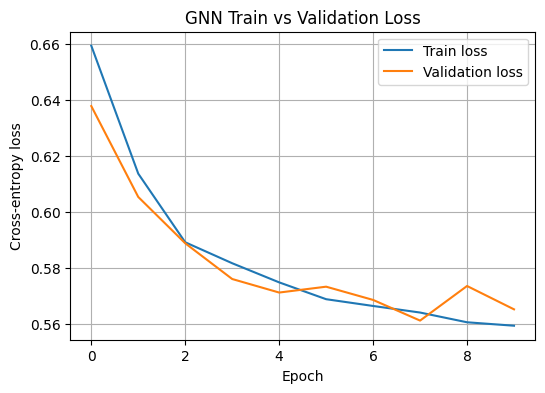

In [259]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.title("GNN Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [260]:
@torch.no_grad()
def get_val_outputs(model, loader, device):
    model.eval()
    scores = []
    labels = []

    for batch in loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)

        prob_higgs = torch.softmax(out, dim=1)[:, 1]
        scores.append(prob_higgs.cpu())
        labels.append(batch.y.cpu())

    return (
        torch.cat(scores).numpy(),
        torch.cat(labels).numpy()
    )

val_scores, val_labels = get_val_outputs(model, val_loader, device)


In [261]:
print(val_scores.shape, val_labels.shape)
print(np.unique(val_labels, return_counts=True))


(7399,) (7399,)
(array([0, 1]), array([3356, 4043]))


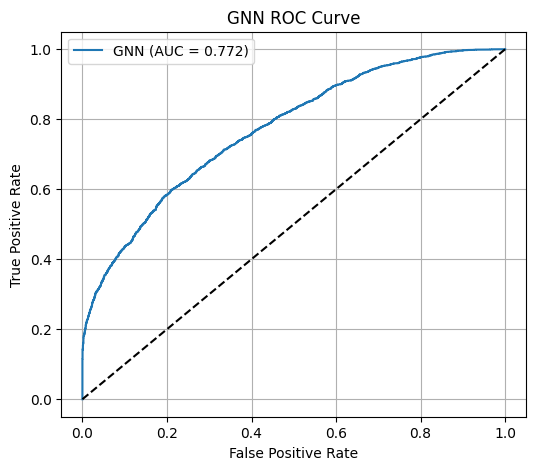

In [262]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(val_labels, val_scores)
auc = roc_auc_score(val_labels, val_scores)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"GNN (AUC = {auc:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("GNN ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [263]:
from sklearn.metrics import confusion_matrix

threshold = 0.5
pred_labels = (val_scores > threshold).astype(int)

cm = confusion_matrix(val_labels, pred_labels)
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

print("Confusion matrix (%):")
print(cm_percent)


Confusion matrix (%):
[[72.91418355 27.08581645]
 [34.70195399 65.29804601]]


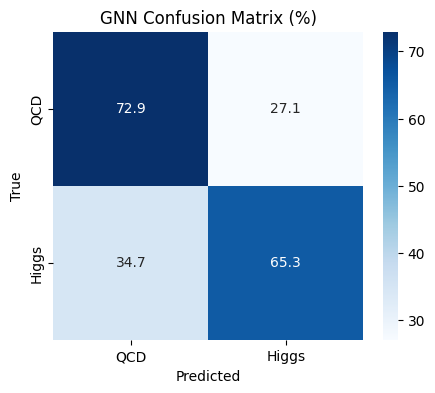

In [264]:
import seaborn as sns

plt.figure(figsize=(5,4))
sns.heatmap(
    cm_percent,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    xticklabels=["QCD", "Higgs"],
    yticklabels=["QCD", "Higgs"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("GNN Confusion Matrix (%)")
plt.show()


In [265]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

acc  = accuracy_score(val_labels, pred_labels)
prec = precision_score(val_labels, pred_labels)
rec  = recall_score(val_labels, pred_labels)
f1   = f1_score(val_labels, pred_labels)

print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1 score : {f1:.3f}")


Accuracy : 0.688
Precision: 0.744
Recall   : 0.653
F1 score : 0.695
